# About Resources

In [1]:
!cat /proc/uptime | awk '{print $1 /60 " mins (" $1 "sec)"}'

6.72033 mins (403.22sec)


In [2]:
!cat /etc/issue

Ubuntu 18.04.3 LTS \n \l



In [3]:
!uname -a

Linux 63ebc90eeb6e 4.14.137+ #1 SMP Thu Aug 8 02:47:02 PDT 2019 x86_64 x86_64 x86_64 GNU/Linux


In [0]:
!df -h

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        586M        8.5G        896K        3.7G         11G
Swap:            0B          0B          0B


In [0]:
!cat /proc/cpuinfo

In [0]:
!nvidia-smi

# Connecting to Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
!ls -l

In [0]:
!ls -l millionlive_idol_prediction/

# Settings

In [12]:
!python --version

Python 3.6.8


In [0]:
%config inlineBackend.figure_format = 'retina'

In [14]:
# 日本語フォントをダウンロード
!apt -y install fonts-ipafont-gothic

# キャッシュを削除
!rm /root/.cache/matplotlib/fontlist-v310.json

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# Training

In [15]:
import torch
import sys, os.path, glob
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

root_dir = './millionlive_idol_prediction/'
idol_script_file = root_dir + 'millionlive_idol_script.csv'
tmp_dir = root_dir + 'tmp/'

max_length = 90
batch_size = 100

class MillionLiveIdolScriptsDataset(Dataset):
    """
    Script dataset of THE IDOLM@STER MILLION LIVE! idols.

    Args:
            csv_file (string): Path to the csv file which contains scripts per an idol.
    """
    
    def __init__(self, csv_file=idol_script_file, transform=None):
        self.idol_data_frame = pd.read_csv(csv_file)
        self.transform = transform

        print(self.idol_data_frame)

    def __len__(self):         
        return len(self.idol_data_frame)
        
    def __getitem__(self, idx):
        _id = self.idol_data_frame.iat[idx, 0] # Integer
        _idol_id = self.idol_data_frame.iat[idx, 1]
        _script = self.idol_data_frame.iat[idx, 2]

        if self.transform:
            _id, _idol_id, _script = self.transform(_id, _idol_id, _script)

        return _id, _idol_id, _script

class StringToTensor(object):
    """
    Convert the id in the sample to Tensors.
    turn a script in the sample into Unicode code points and convert it to Tensors.
    """

    def __init__(self, max_length):
        self.max_length = max_length
    
    def __string_to_codepoint(self, _str):
        _encoded_str = [ord(_x) for _x in str(_str).strip()]
        # Return an encoded string as an array like below.
        # [12450, 12452, 12489, 12523, 12395, 12394, 12387, 12390, 12289, 31169, 12398, 22818, 12395, 33394, 12364, 12388, 12365, 12414, 12375, 12383, 12290, 20449, 12376, 12390, 27497, 12365, 32154, 12369, 12390, 12356, 12428, 12400, 12289, 12365, 12387, 12392, 12289, 12356, 12388, 12363, 8230, 12290, 12503, 12525, 12487, 12517, 12540, 12469, 12540, 12290, 31169, 12289, 32118, 23550, 12395, 23626, 12369, 12390, 12415, 12379, 12414, 12377, 12397, 65281]
        _encoded_str = _encoded_str[:self.max_length]
        _str_len = len(str(_str)) # String length
        if _str_len < self.max_length: # If string length is less than a num of max_length, do zero padding
            _encoded_str += ([0] * (self.max_length - _str_len))
        
        return _encoded_str

    def __call__(self, _id, _idol_id, _script):
        
        _script = self.__string_to_codepoint(_script)

        return _id, _idol_id, torch.tensor(_script, dtype=torch.long)
    
class CLCNN(nn.Module):
    def __init__(self, max_length, output_dim, embed_size=128, filter_sizes=(1, 2, 3, 4, 5), filter_num=200, dropout=0.5):
        super(CLCNN, self).__init__() # Call the method of this super class
        
        self.emb = nn.Embedding(0xffff, embed_size, padding_idx=0) # Get only kinds of three-byte characters of UTF-8
        self.convs1 = nn.ModuleList([nn.Conv2d(1, filter_num, (k, embed_size)) for k in filter_sizes])
        self.bns1 = nn.ModuleList([nn.BatchNorm2d(filter_num, momentum=0.11) for _ in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(filter_num * len(filter_sizes), output_dim)

   
    def forward(self, x):
        #print('input:', x.size())
        out = self.emb(x) # (N,W,D)
        #print('emb:', out.size())
        emb_out = out.unsqueeze(1) # Insert a dimension (N,Ci,W,D)
        #print('emb_ex:', emb_out.size())
        relu_bn_out = [F.relu(bn(conv(emb_out))).squeeze(3) for conv, bn in zip(self.convs1, self.bns1)] #[(N,Co,W), ...]*len(Fs)
        maxpool_out = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in relu_bn_out] #[(N,Co), ...]*len(Fs)
        concated_out = torch.cat(maxpool_out, 1)
        #print('concatnated:', concated_out.size())
        dropped_out = self.dropout(concated_out)
        out = self.fc1(dropped_out) # (N,len(Ks)*Co)
        #print('output:', out.size())
        
        return out
        
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (labels, idol_ids, scripts)  in enumerate(train_loader):
        labels = labels.to(device)
        scripts = scripts.to(device)

        optimizer.zero_grad()
        outputs = model(scripts)

        loss = criterion(outputs, labels) # https://pytorch.org/docs/stable/nn.html#crossentropyloss one-hotにしなくてもOK!
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / len(train_loader)

    return train_loss

def valid(model, optimizer, criterion, test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (labels, idol_ids, scripts)  in enumerate(test_loader):
            labels = labels.to(device)
            scripts = scripts.to(device)

            outputs = model(scripts)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1] # Get the index of the max log-probability
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            total += labels.size(0) # Dim 0 is Batch size
    
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc

def fit(model, optimizer, criterion, train_loader, test_loader, learning_rate, num_epochs):
    loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        val_loss, val_acc = valid(model, optimizer, criterion, test_loader)

        print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))

        # Logging
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    print('Finished training.')
    
    # Save the trained model
    #np.save('loss_list.npy', np.array(loss_list))
    #np.save('val_loss_list.npy', np.array(val_loss_list))
    #np.save('val_acc_list.npy', np.array(val_acc_list))
    torch.save(model.state_dict(), root_dir + 'clcnn.pkl')
    
    return loss_list, val_loss_list, val_acc_list

def plot_history(loss_list, val_loss_list, val_acc_list):
    # Plot loss curve
    display('Model Loss')
    plt.plot(loss_list,".-",label="loss",)
    plt.plot(val_loss_list,".-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Plot accurancy curve
    display('Model Acc')
    #plt.plot(history.history['acc'],".-",label="accuracy")
    plt.plot(val_acc_list,".-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def result_report(model, test_loader):
    global idol_dict
    # Classification Report
    y_true = []
    y_pred = []
    for i, (y, z, x) in enumerate(test_loader):
        y = y.to(device)
        x = x.to(device)

        with torch.no_grad():
            output = model(x)
        y_pred += [idol_dict[int(l.argmax())] for l in output]
        y_true += [idol_dict[int(l)] for l in y]

    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(20, 20))
    labels = [idol_dict[i] for i in range(len(idol_dict))]
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    cmx_df = pd.DataFrame(cmx_data, index=labels, columns=labels)
    sns.heatmap(cmx_df, square=True, annot=True, cmap='Blues')
    plt.savefig(root_dir + 'cmx.png')

Device: cuda


In [16]:
!pip install adabound

In [17]:
import adabound

# Million Live Idol Scripts Dataset (Scripts and Labels)
transformed_script_dataset = MillionLiveIdolScriptsDataset(transform=StringToTensor(max_length))
# Split dataset
train_data, test_data = train_test_split(transformed_script_dataset, test_size=0.25)
# Dataset loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=10)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=10)

"""
for i_batch, (id, idol_id, script)  in enumerate(train_loader):
    print('index:', i_batch)
    print('id:', id.size())
    print('idol_id:', idol_id)
    print('script:', script.size())
"""
learning_rate = 1e-3
num_epochs = 30
output_dim = 50

# Build the model
model = CLCNN(max_length=max_length, output_dim=output_dim).to(device)
optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=0.1, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

# Generate an idol dictionary
idol_df = transformed_script_dataset.idol_data_frame.set_index('id')
idol_dict = idol_df['idol_id'].drop_duplicates().to_dict()

      id idol_id                                             script
0      0  haruka                 トップアイドル目指して、歌も踊りも頑張ります！よろしくお願いします♪
1      0  haruka                               お仕事、頑張るぞー！なーんて、えへへ…。
2      0  haruka                                   張り切っていっちゃいましょうっ！
3      0  haruka                      あの、クッキー焼いてきたんですけど、食べてもらえますか…？
4      0  haruka                              プロデューサーさん、いつもお疲れさまです♪
...   ..     ...                                                ...
8577  49  sayoko  終わった後のことなんて、考えません！ただ、私の精一杯の歌とダンスを、ファンのみんなに見てもら...
8578  49  sayoko                                           アイドルになって
8579  49  sayoko  見てください、プロデューサー。この衣装、動くと綺麗な音が鳴るんですよ！…ほら、なんて素敵な音...
8580  49  sayoko                                           アイドルになって
8581  49  sayoko  アイドルになって、私の夢に色がつきました。信じて歩き続けていれば、きっと、いつか…。プロデュ...

[8582 rows x 3 columns]
CLCNN(
  (emb): Embedding(65535, 128, padding_idx=0)
  (convs1): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(1, 128), stride=(1, 1))
    (1): Conv2d(1, 20

In [18]:
# Fit
loss_list, val_loss_list, val_acc_list = fit(model, optimizer, criterion, train_loader, test_loader, learning_rate, num_epochs)

epoch 0, loss: 5.0230 val_loss: 3.0904 val_acc: 0.2218
epoch 1, loss: 3.3002 val_loss: 2.3355 val_acc: 0.3816
epoch 2, loss: 2.5884 val_loss: 2.0529 val_acc: 0.4529
epoch 3, loss: 2.2080 val_loss: 2.0337 val_acc: 0.4711
epoch 4, loss: 1.9256 val_loss: 1.8561 val_acc: 0.4832
epoch 5, loss: 1.7349 val_loss: 1.7473 val_acc: 0.5070
epoch 6, loss: 1.5769 val_loss: 1.7223 val_acc: 0.5172
epoch 7, loss: 1.4992 val_loss: 1.6448 val_acc: 0.5373
epoch 8, loss: 1.3662 val_loss: 1.6564 val_acc: 0.5270
epoch 9, loss: 1.2832 val_loss: 1.6184 val_acc: 0.5405
epoch 10, loss: 1.1980 val_loss: 1.6517 val_acc: 0.5349
epoch 11, loss: 1.1246 val_loss: 1.4843 val_acc: 0.5727
epoch 12, loss: 1.0483 val_loss: 1.5787 val_acc: 0.5582
epoch 13, loss: 1.0108 val_loss: 1.5117 val_acc: 0.5760
epoch 14, loss: 0.9505 val_loss: 1.5540 val_acc: 0.5587
epoch 15, loss: 0.8646 val_loss: 1.5171 val_acc: 0.5764
epoch 16, loss: 0.8188 val_loss: 1.5339 val_acc: 0.5727
epoch 17, loss: 0.7631 val_loss: 1.4982 val_acc: 0.5801
ep

## Model Loss and Model Accuracy

'Model Loss'

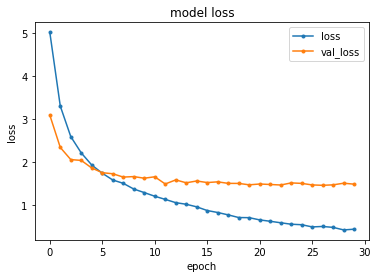

'Model Acc'

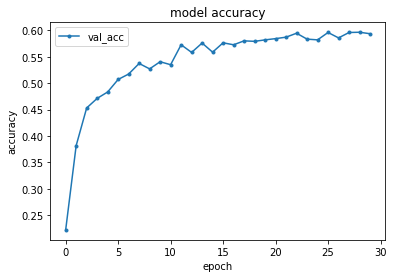

In [19]:
plot_history(loss_list, val_loss_list, val_acc_list)

## Evaluation

              precision    recall  f1-score   support

       akane       0.93      0.89      0.91        45
         ami       0.57      0.56      0.57        41
        anna       0.82      0.73      0.77        49
       arisa       0.61      0.71      0.66        35
       ayumu       0.57      0.36      0.44        33
       azusa       0.44      0.28      0.34        39
     chihaya       0.61      0.28      0.39        39
     chizuru       0.91      0.80      0.85        40
       elena       0.87      0.97      0.92        40
       emily       0.86      0.64      0.74        39
      haruka       0.52      0.26      0.35        46
      hibiki       0.57      0.79      0.66        43
      hinata       0.77      0.71      0.74        38
        huka       0.42      0.11      0.18        44
         iku       0.50      0.66      0.57        35
        iori       0.81      0.68      0.74        50
       julia       0.77      0.75      0.76        44
        kana       0.45    

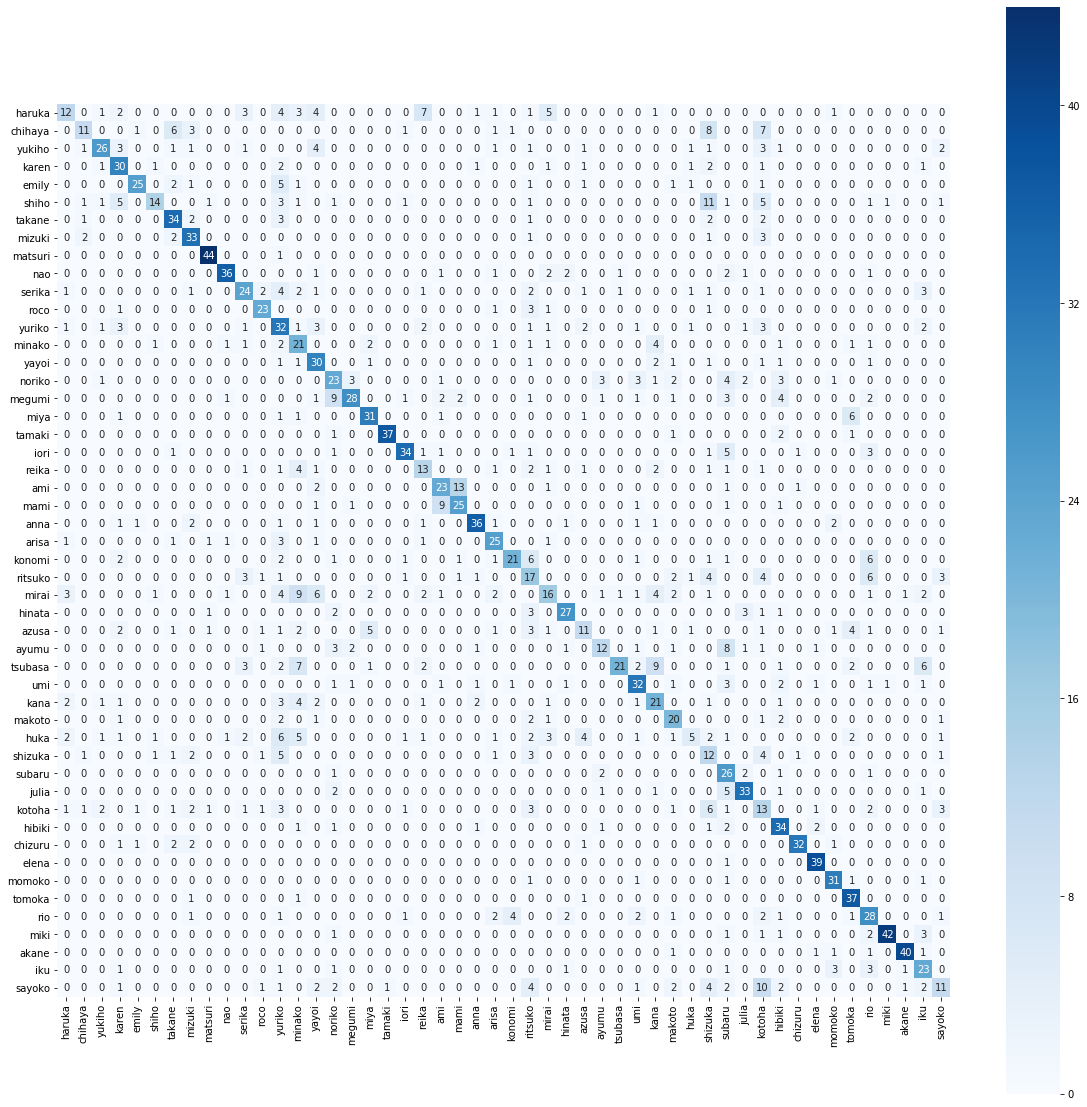

In [20]:
result_report(model, test_loader)

# Prediction

In [0]:
def string_to_codepoint(_str, max_length=max_length):
    _encoded_str = [ord(_x) for _x in str(_str).strip()]
    _encoded_str = _encoded_str[:max_length]
    _str_len = len(str(_str)) # String length
    if _str_len < max_length: # If string length is less than a num of max_length, do zero padding
        _encoded_str += ([0] * (max_length - _str_len))
    
    return _encoded_str

In [0]:
def predict(input_str, model=model):
    encoded_str = torch.LongTensor(string_to_codepoint(input_str)).unsqueeze(0).to(device)
    model = model.eval()
    with torch.no_grad():
        result = model(encoded_str)
    #print(result.cpu().argmax().item())
    res_df = pd.DataFrame(result.cpu().numpy())
    res_df.rename(columns=idol_dict, index={0: 'score'}, inplace=True)
    res_df = res_df.T.sort_values('score', ascending=False)
    return res_df

# Analysis

In [0]:
class GradCAM(nn.Module):
    def __init__(self, model, feature_layer):
        super(GradCAM, self).__init__()

        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層の逆伝播時の勾配を記録
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]]).to(device)
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [0]:
def codepoint_to_string(codepoints):
    decoded_str_list = []
    for _x in codepoints:
        if _x == 0:
            decoded_str_list += '－'
        if _x != 0:
            decoded_str_list += chr(_x)
    decoded_str = ''.join(decoded_str_list)

    return decoded_str

In [0]:
def n_gram(target, n):
    return [ target[idx:idx + n] for idx in range(len(target) - n + 1)]

In [0]:
def gen_feature_heatmap(input_source, input_model=model):
    test_tensor = torch.LongTensor(string_to_codepoint(input_source)).unsqueeze(0).to(device)
    #test_tensor = test_data[1][2].unsqueeze(0).to(device) # nao
    reverse_zero_padd_str = codepoint_to_string(test_tensor.tolist()[0])
    print(reverse_zero_padd_str)
    for i in range(len(input_model.convs1)):
        # Grad-CAMのインスタンス生成
        grad_cam = GradCAM(model=input_model, feature_layer=model.convs1[i])
        # モデルでの順伝播
        model_output = grad_cam.forward(test_tensor).to(device)
        predicted_label = torch.LongTensor([model_output.argmax().item()]).to(device)
        # 予測したラベルに対する逆伝播を計算
        grad_cam.backward_on_target(model_output, predicted_label)
        # 各特徴マップの要素に対する勾配を取得して平滑化
        feature_grad = grad_cam.feature_grad.cpu().data.numpy()[0]
        weights = np.mean(feature_grad, axis=(1, 2))
        # 重みを特徴マップに掛け合わせ後にReLUを適用
        feature_map = grad_cam.feature_map.cpu().data.numpy()
        cam = np.sum((weights * feature_map.T), axis=2).T
        cam = np.maximum(cam, 0)
        #print(pd.DataFrame(cam))
        # hookの初期化
        grad_cam.clear_hook()

        label_list = n_gram(reverse_zero_padd_str, i+1) # iはfilter_size
        cam_df = pd.DataFrame(cam, index=label_list)     
        print(cam_df)
        # ヒートマップの表示
        #print(pd.DataFrame(cam))
        plt.figure(figsize=(10, 15))
        sns.set(font='IPAGothic')
        sns.heatmap(cam_df, annot=True, fmt='.3f',robust=True)
        plt.savefig(root_dir + 'gradcam_result_filter_size_{}.png'.format(i))

In [27]:
test_source = input('type a script:')

type a script:姫はお味噌汁より松茸のお吸い物が好きなのです♪……そろそろ季節ですね？ ね？


In [28]:
!pip install matplotlib==3.1.0

In [29]:
predict(test_source)

,score
matsuri,10.175033
yuriko,5.032890
tomoka,4.312469
ritsuko,3.676975
chizuru,3.168185
momoko,3.025139
anna,2.839159
takane,2.631114
shizuka,2.566072
emily,2.408386


姫はお味噌汁より松茸のお吸い物が好きなのです♪……そろそろ季節ですね？ ね？－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
           0
姫   0.028595
は   0.002885
お   0.000560
味   0.009319
噌   0.007358
..       ...
－   0.000000
－   0.000000
－   0.000000
－   0.000000
－   0.000000

[90 rows x 1 columns]
           0
姫は  0.000334
はお  0.005184
お味  0.009100
味噌  0.000000
噌汁  0.000000
..       ...
－－  0.000000
－－  0.000000
－－  0.000000
－－  0.000000
－－  0.000000

[89 rows x 1 columns]
            0
姫はお  0.001094
はお味  0.010186
お味噌  0.000915
味噌汁  0.000000
噌汁よ  0.003951
..        ...
－－－  0.001579
－－－  0.001579
－－－  0.001579
－－－  0.001579
－－－  0.001579

[88 rows x 1 columns]
             0
姫はお味  0.010165
はお味噌  0.000681
お味噌汁  0.014244
味噌汁よ  0.000000
噌汁より  0.012430
...        ...
－－－－  0.008108
－－－－  0.008108
－－－－  0.008108
－－－－  0.008108
－－－－  0.008108

[87 rows x 1 columns]
              0
姫はお味噌  0.000000
はお味噌汁  0.008189
お味噌汁よ  0.008437
味噌汁より  0.018329
噌汁より松  0.008050
...         ...
－－－－－  0.012092
－－－－－  0.012092
－－－－－  0.0120

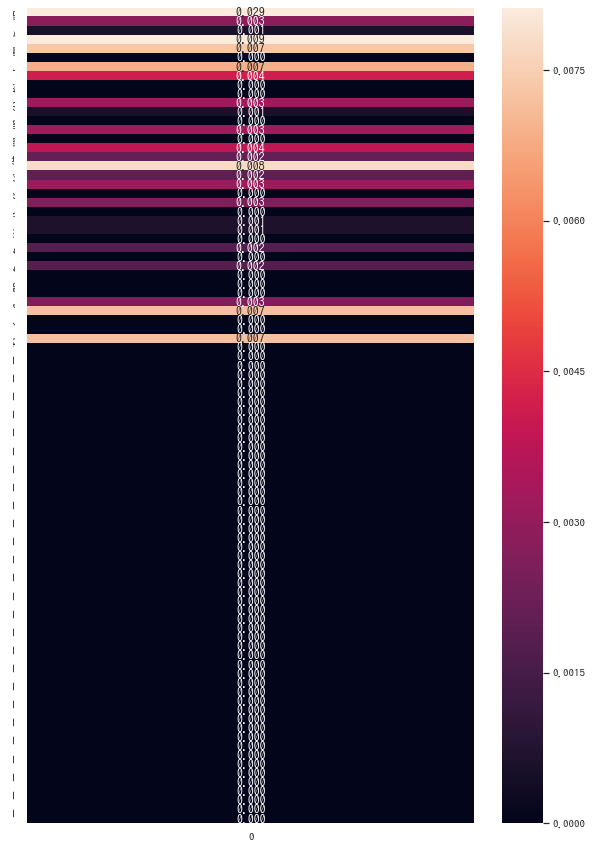

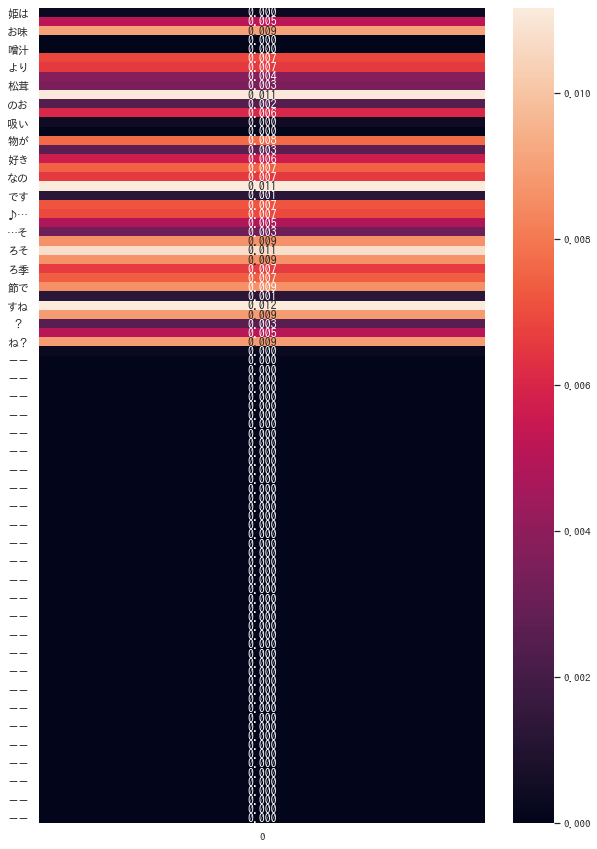

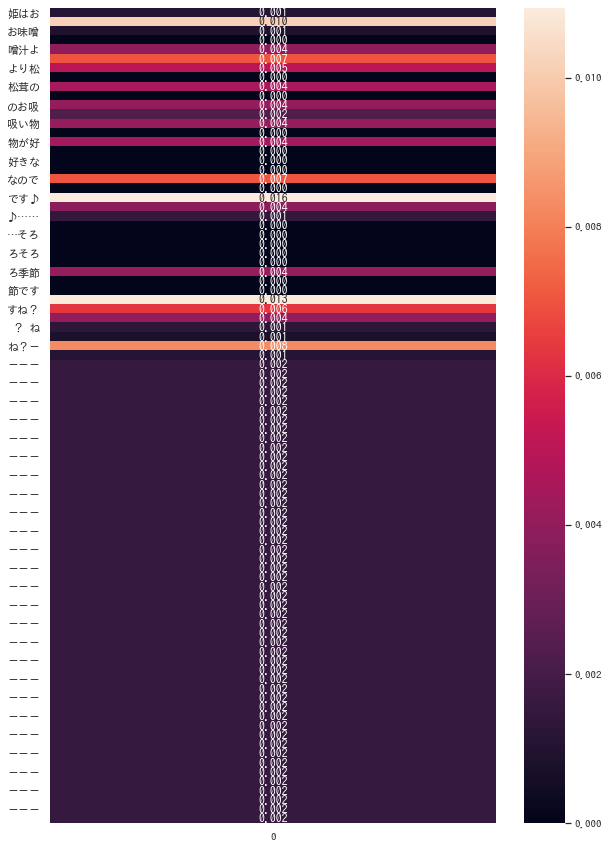

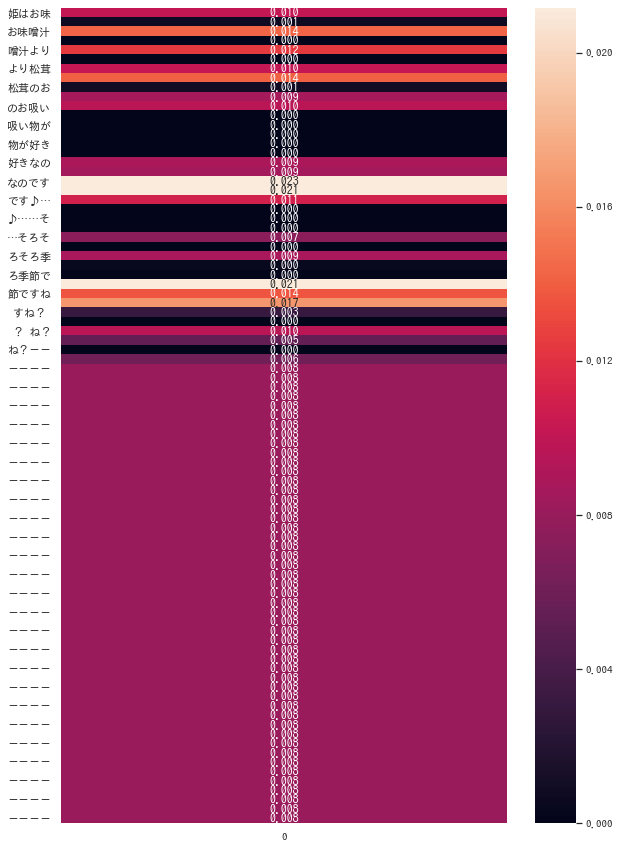

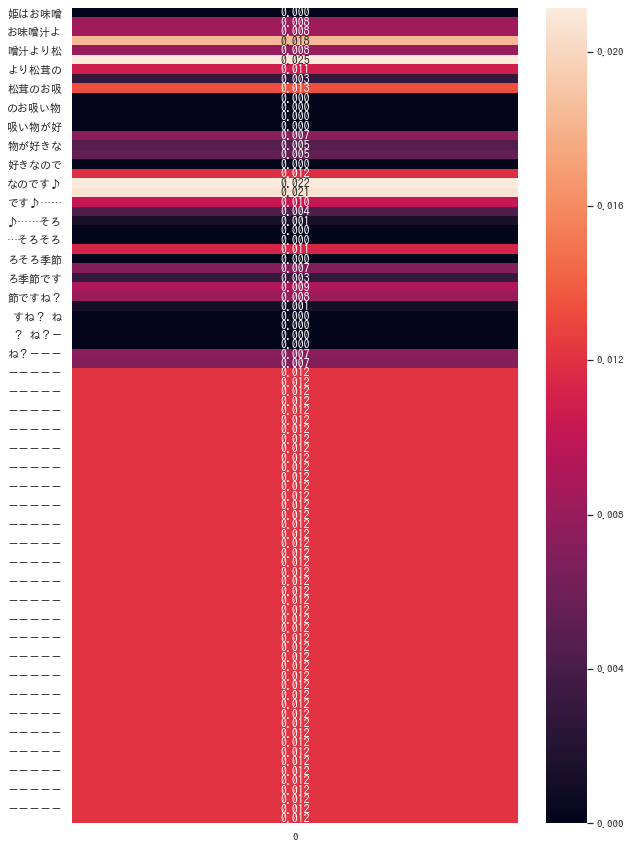

In [30]:
gen_feature_heatmap(test_source)